# Model comparison 31D

This notebook is used to visualize the compression errors of AEs trained on a 31-dimensional jet dataset.

In [1]:
import os
import uproot
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import corner

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse
from fastai.callback import schedule

import vector

import glob

In [2]:
plt.rcParams.update({'font.size': 16, 'lines.markersize' : 10, 'image.cmap' : 'tab20b'})

In [3]:
# Set up branch information

# Specify whether to include calculated energy or mass as the fourth four-momentum variable
b_file = open('branches_E.txt', 'r')
#b_file = open('branches_m.txt', 'r')

branches = []
for line in b_file.readlines():
    if line[0] != '#':
        branches.append(line.replace('\n', ''))
b_file.close()
print('Number of branches selected:', len(branches), '\n')
res_type = pd.read_pickle('res_types.pkl')

Number of branches selected: 31 



In [4]:
# Load information and filenames for results of all models. Note that the 31D evaluation uses the old directory structure

# From a specific set of runs
#run_nrs = [20211104132919, 20211024192654]
run_nrs = [20211024192654, 20211024224338, 20211024224522, 20211025092823, 20211024224616] # These are all the N x 31 runs

orig_pred_path = r'F:\Master\Data\storage\orig-pred'
info_path = r'F:\Master\Data\storage\model-info'

all_files_nested = []
for run_nr in run_nrs:
    all_files_nested.append(glob.glob(os.sep.join([orig_pred_path, 'run_' + str(run_nr) + '*'])))
all_files = []
model_names = []
for sublist in all_files_nested:
    for file in sublist:
        model_name = file[file.rfind('run'):file.rfind('orig-pred.pkl')]
        if model_name[-1] == '_':
            model_name = model_name[:-1]
        #if not pd.read_pickle(os.sep.join([info_path, model_name+'.info']))[0]['group_size'] == 5:
        all_files.append(file)
        model_names.append(model_name)

In [5]:
# Extract quartile, standard deviation and median information for the errors of all AE models

percentile_values = [0.5, 99.5]
#percentile_values = [0, 100]

origs = {}
preds = {}
all_res = {}
means = {}
stds = {}
boxes = {}
for i, file in enumerate(all_files):
    origs[model_names[i]], preds[model_names[i]] = pd.read_pickle(file)
    #all_res[model_names[i]] = preds[model_names[i]] - origs[model_names[i]]
    temp_res = preds[model_names[i]] - origs[model_names[i]]
    means[model_names[i]] = {'response' : {}, 'residual' : {}}
    stds[model_names[i]] = {'response' : {}, 'residual' : {}}
    boxes[model_names[i]] = {'response' : {}, 'residual' : {}}
    for branch in branches:
        if res_type[branch] == 'response':
            #all_res[model_names[i]][branch] /= origs[model_names[i]][branch]
            temp_res[branch] /= origs[model_names[i]][branch]
        temp_percentiles = np.percentile(temp_res[branch], percentile_values)
        mask = (temp_res[branch] > temp_percentiles[0]) & (temp_res[branch] < temp_percentiles[1])
        means[model_names[i]][res_type[branch]][branch] = temp_res[branch][mask].mean()
        stds[model_names[i]][res_type[branch]][branch] = temp_res[branch][mask].std()
        
        median = np.median(temp_res[branch])
        q1 = np.median(temp_res[branch][temp_res[branch] < median])
        q3 = np.median(temp_res[branch][temp_res[branch] > median])
        iqr = q3 - q1
        low = q1 - 1.5*iqr
        high = q3 + 1.5*iqr
        lower_p = np.percentile(temp_res[branch], percentile_values[0])
        upper_p = np.percentile(temp_res[branch], percentile_values[1])
        n_outliers = sum(temp_res[branch] < low) + sum(temp_res[branch] > high)
        boxes[model_names[i]][res_type[branch]][branch] = {'median' : median,
                                                          'q1' : q1,
                                                          'q3' : q3,
                                                          'low' : low,
                                                          'high' : high,
                                                          'n_outliers' : n_outliers,
                                                          'max' : temp_res[branch].max(),
                                                          'min' : temp_res[branch].min(),
                                                          'lower_p' : lower_p,
                                                          'upper_p' : upper_p,
                                                          'iqr' : iqr}
    all_res[model_names[i]] = temp_res

info = {}
for model_name in model_names:
    info[model_name] = pd.read_pickle(os.sep.join([info_path, model_name+'.info']))[0]

In [6]:
# model_names list sorter
# sorting is in the order of: mode - group size (ascending) - compression ratio (ascending)

modes = ['same_event', 'random', 'pt_sort']
group_sizes = [1, 2, 3]
new_name_list = []
for mode in modes:
    for group_size in group_sizes:
        part_list = []
        for model_name in model_names:
            if (info[model_name]['mode'] == mode) & (info[model_name]['group_size'] == group_size):
                part_list.append(model_name)
        latent_space_sizes = []
        for name in part_list:
            latent_space_sizes.append(info[name]['latent_space_size'])
        part_list = np.array(part_list)[np.flip(np.argsort(latent_space_sizes))]
        for part in part_list:
            new_name_list.append(part)
model_names = new_name_list

In [65]:
info_df = pd.DataFrame(info).transpose()
info_df['comp_ratio'] = (info_df['n_features'] + info_df['intermediate']) * info_df['group_size'] / info_df['latent_space_size']
info_df = info_df.sort_values(['mode', 'comp_ratio', 'group_size'], ascending=[False, True, True])

# Masking model selection
all_model_names = np.array(list(info_df.index))

# Different masks used to view subsets of the set of AE models
#mask = [boxes[model_name]['response']['JetEtaJESScaleMomentum_pt']['iqr'] < 0.2 for model_name in all_model_names]
#mask = info_df['comp_ratio'] <= 1.34
#mask = info_df['mode'] == 'pt_sort'
mask = (info_df['group_size'] != 4) & (info_df['group_size'] != 5)
#mask = [True] * len(info_df)

info_df = info_df[mask]

model_names = list(info_df.index)
group_sizes = np.unique(info_df['group_size'])

In [66]:
# sort models based on iqr score and make a reduced selection
# the iqr score is calculated in the following manner:
# for each variable, calculate the inter-quartile range (iqr) of all models
# sort the list of models by their iqr
# for each model, add the index of its place in this sorted list to the iqr score of that model
# 
# so, a model with an iqr score of 0 has had the lowest iqr of all models for all variables
# in practice, no model will score the best for all variables, but the best models will have an iqr score close to zero

model_scores = dict(zip(model_names, [0] * len(model_names)))
for branch in branches:
    iqrs = []
    for model_name in model_names:
        iqrs.append(boxes[model_name][res_type[branch]][branch]['iqr'])
    iqrs = np.sort(iqrs)
    for model_name in model_names:
        model_scores[model_name] += np.where(iqrs == boxes[model_name][res_type[branch]][branch]['iqr'])[0][0]
sort_order = np.array(list(model_scores.values())).argsort()
#model_names = np.array(model_names)[sort_order]

In [67]:
# list models with compression ratios and iqr scores

comp_ratios = np.unique(info_df['comp_ratio'])
for comp_ratio in comp_ratios:
    for key in np.array(list(model_scores.keys()))[sort_order]:
        this_comp_ratio = 31 * info[key]['group_size'] / info[key]['latent_space_size']
        if this_comp_ratio == comp_ratio:
            print('{:36} {:5.2f} {:>4}'.format(key, comp_ratio, model_scores[key]))
    print()

run_20211024192654_random_1_24        1.29   25
run_20211024192654_same_event_1_24    1.29   36
run_20211024192654_pt_sort_1_24       1.29   82
run_20211024224338_pt_sort_2_48       1.29  136
run_20211024224338_same_event_2_48    1.29  197
run_20211024224338_random_2_48        1.29  219
run_20211024224522_pt_sort_3_72       1.29  250
run_20211024224522_same_event_3_72    1.29  314
run_20211024224522_random_3_72        1.29  335

run_20211024192654_random_1_20        1.55  210
run_20211024192654_pt_sort_1_20       1.55  224
run_20211024192654_same_event_1_20    1.55  237
run_20211024224338_pt_sort_2_40       1.55  354
run_20211024224338_same_event_2_40    1.55  423
run_20211024224338_random_2_40        1.55  428
run_20211024224522_pt_sort_3_60       1.55  499
run_20211024224522_random_3_60        1.55  511
run_20211024224522_same_event_3_60    1.55  536

run_20211024192654_pt_sort_1_16       1.94  520
run_20211024192654_same_event_1_16    1.94  585
run_20211024192654_random_1_16        

In [10]:
for model_name in np.array(model_names)[sort_order][[1, 0, 2]]:
    datas = []
    for param in ['low', 'q1', 'median', 'q3', 'high']:
        datas.append(boxes[model_name][res_type[branches[0]]][branches[0]][param])
    print('{:35} {:.5f} {}'.format(model_name, boxes[model_name][res_type[branches[0]]][branches[0]]['iqr'], datas))

run_20211024192654_same_event_1_24  0.01675 [-0.03403857722878456, -0.008913258, -0.00058308354, 0.007836955, 0.03296227380633354]
run_20211024192654_random_1_24      0.01319 [-0.026363994926214218, -0.006575674, -0.00026337785, 0.00661654, 0.026404860895127058]
run_20211024192654_pt_sort_1_24     0.01912 [-0.038654194213449955, -0.009981047, -0.00072227354, 0.009134384, 0.03780753072351217]


# Box plots of all responses and residuals

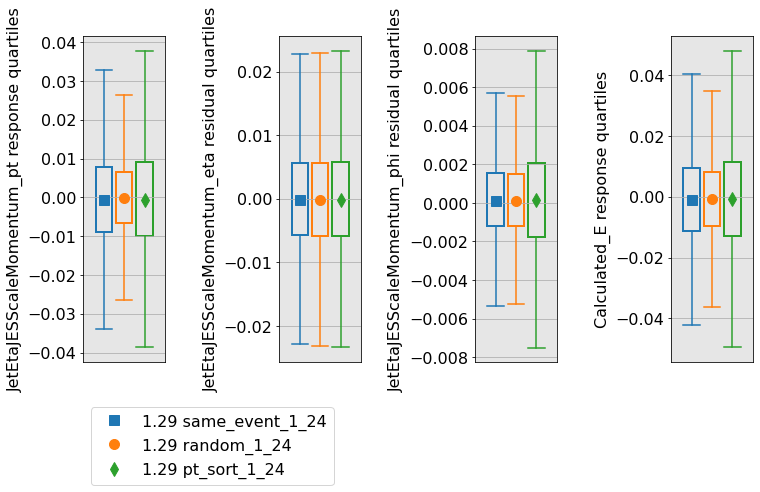

In [11]:
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

markers = {'same_event' : 's',
           'random' : 'o',
           'pt_sort' : 'd'}

# Use either iqr or percentiles to define whiskers
whisker_def = ['low', 'high'] # iqr outlier definition
#whisker_def = ['lower_p', 'upper_p'] # percentile outlier definition

# Select a subset of variables to view
selected_branches = branches[:4]
n_plots = len(selected_branches)

#colors = plt.get_cmap('tab20b').colors[:4*len(group_sizes)] # Set the cut-off in colors = the number of models using each mode. If there are more than 20 models using a certain mode, a larger color map needs to be used.
colors = plt.get_cmap('tab10').colors

#fig = plt.figure(figsize = (18, int(np.ceil(n_plots/2))*5.5))
fig = plt.figure(figsize = (12, int(np.ceil(n_plots/2))*3))

n_columns = 2

for pos, model_name in enumerate (np.array(model_names)[sort_order][[1, 0, 2]]): # enumerate(model_names):
    
    mode = info[model_name]['mode']
    
    for plot, branch in enumerate(selected_branches):
        #ax = plt.subplot(int(np.ceil(n_plots/2)), n_columns, plot+1)
        ax = plt.subplot(1, 4, plot + 1)
        col = pos
        if col > len(colors) - 1:
            col = col % len(colors)
        color = colors[col]
        
        box = boxes[model_name][res_type[branch]][branch]
        
        top = box[whisker_def[1]] + 0.1*np.abs(box[whisker_def[1]])
        bot = box[whisker_def[0]] - 0.1*np.abs(box[whisker_def[0]])
        
        #top = box['max'] + 0.1*np.abs(box['max'])
        #bot = box['min'] - 0.1*np.abs(box['min'])
        
        if pos == 0:
            ax.set_ylim((bot, top))
        else:
            y_bot, y_top = ax.get_ylim()        
            if top > y_top:
                y_top = top
            if bot < y_bot:
                y_bot = bot
            ax.set_ylim((y_bot, y_top))
        
        rect_width = 0.8
        rect_corner = (pos-rect_width/2, box['q1'])
        rect_height = box['q3'] - box['q1']
        ax.add_patch(Rectangle(rect_corner, rect_width, rect_height, linewidth=2, edgecolor=color, facecolor='none'))
        
        ax.add_line(Line2D((pos-rect_width/2, pos+rect_width/2), (box[whisker_def[1]], box[whisker_def[1]]), color=color))
        ax.add_line(Line2D((pos-rect_width/2, pos+rect_width/2), (box[whisker_def[0]], box[whisker_def[0]]), color=color))
        ax.add_line(Line2D((pos, pos), (box['q3'], box[whisker_def[1]]), color=color))
        ax.add_line(Line2D((pos, pos), (box['q1'], box[whisker_def[0]]), color=color))
        
        # Using max and min instead of high and low
        #ax.add_line(Line2D((pos-rect_width/2, pos+rect_width/2), (box['max'], box['max']), color=color))
        #ax.add_line(Line2D((pos-rect_width/2, pos+rect_width/2), (box['min'], box['min']), color=color))
        #ax.add_line(Line2D((pos, pos), (box['q3'], box['max']), color=color))
        #ax.add_line(Line2D((pos, pos), (box['q1'], box['min']), color=color))
        
        comp_ratio = info[model_name]['n_features'] * info[model_name]['group_size'] / info[model_name]['latent_space_size']
        plt.plot(pos, box['median'], linewidth=0, marker=markers[mode], color=color, label='{:.2f} {}'.format(comp_ratio, info[model_name]['name']))
        

for plot, branch in enumerate(selected_branches):
    #plt.subplot(int(np.ceil(n_plots/2)), n_columns, plot+1)
    plt.subplot(1, 4, plot + 1)
    
    quantile_str = 'quantiles'
    if whisker_def[0] == 'low':
        quantile_str = 'quartiles'
    #plt.title(branch + ' ' + res_type[branch] + ' ' + quantile_str, pad=10)
    plt.ylabel(branch + ' ' + res_type[branch] + ' ' + quantile_str)
    ax = plt.gca()
    ax.set_facecolor((0.9, 0.9, 0.9))
    #lims = ax.set_ylim([-0.002, 0.002])
    ax.set_xlim((-1, pos + 1))
    ax.set_xticks([])
    plt.grid(axis='y')
    
    if len(selected_branches) < 31:
        if plot in [0, 6, 14, 22]:
            plt.legend(loc='lower left', bbox_to_anchor=(0, -.4), ncol=1);
    if plot == 30:
        plt.legend(loc='lower left', bbox_to_anchor=(0, -1.25), ncol=3);

#plt.subplots_adjust(wspace=0.15)
plt.subplots_adjust(wspace=1.4)

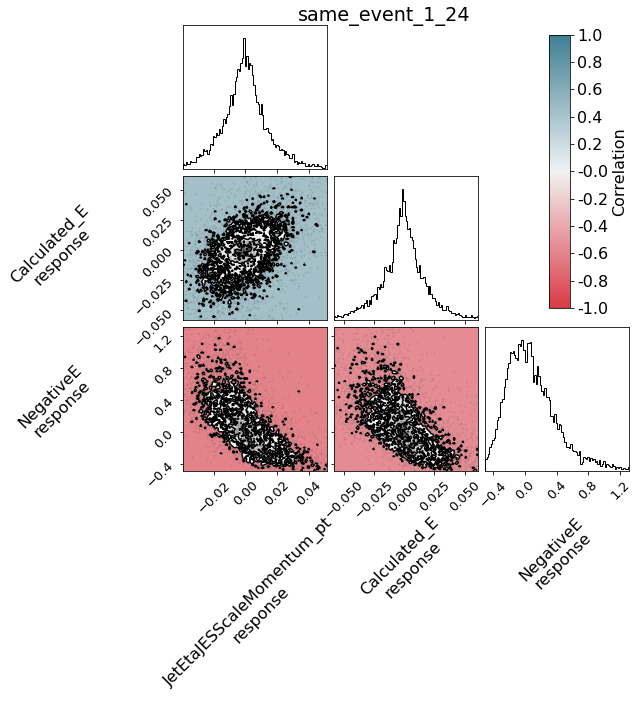

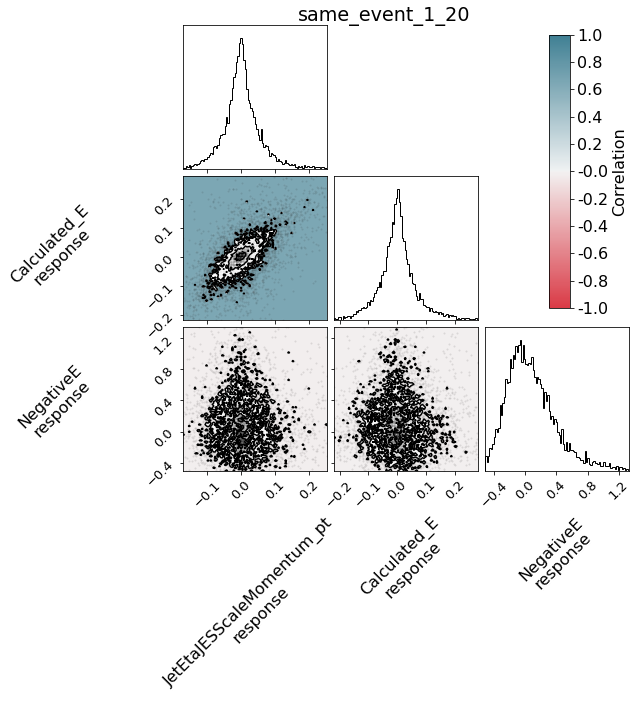

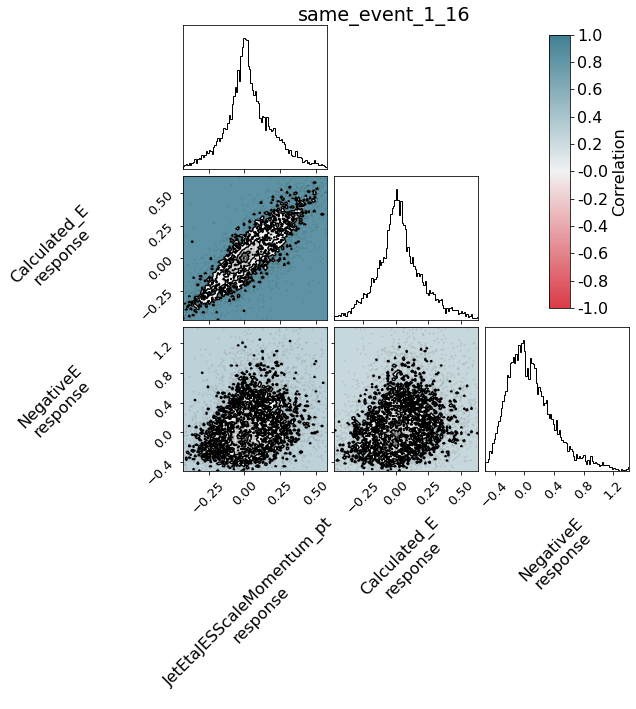

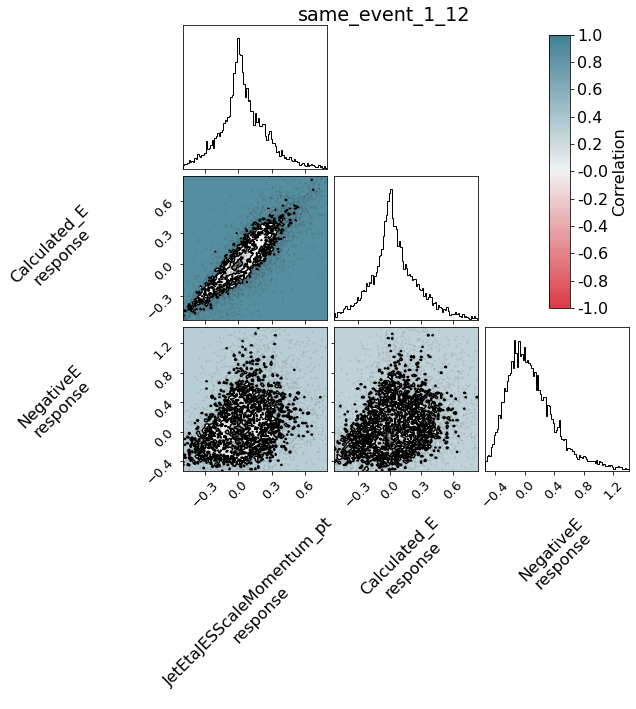

In [64]:
# view corner plots of specified models and variables

#selected_branches = ['JetEtaJESScaleMomentum_pt', 'JetEtaJESScaleMomentum_eta', 'JetEtaJESScaleMomentum_phi', 'Calculated_E', 'NegativeE']
selected_branches = ['JetEtaJESScaleMomentum_pt', 'Calculated_E', 'NegativeE']
#selected_branches = [branch for branch in branches if 'Active' in branch or 'phi' in branch or 'Phi' in branch]
#selected_branches = branches

#for model_name in ['run_20211024192654_same_event_1_12', 'run_20211024192654_random_1_12', 'run_20211024192654_pt_sort_1_12']:
for model_name in ['run_20211024192654_same_event_1_' + nr for nr in ['24', '20', '16', '12']]:
#for model_name in ['run_20211024192654_random_1_' + nr for nr in ['24', '20', '16', '12']]:
#for model_name in ['run_20211024192654_pt_sort_1_' + nr for nr in ['24', '20', '16', '12']]:
#for model_name in ['run_20211024224338_same_event_2_' + nr for nr in ['48', '40', '32', '24']]:
#for model_name in model_names:
    
    res = all_res[model_name][selected_branches]
    figure = corner.corner(res, bins=100, range=[tuple(np.percentile(res[branch], (1, 99))) for branch in selected_branches], labels=[branch + '\n' + res_type[branch] for branch in selected_branches], label_kwargs={'rotation' : 45})
    ndim = len(selected_branches)
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    norm = plt.Normalize(-1, 1)

    axes = figure.axes
    for ax in axes:
        labels = (ax.get_xlabel(), ax.get_ylabel())
        ax.set_xlabel(labels[0], position=(.5, -.3))
        ax.set_ylabel(labels[1], position=(-.8, .4))
        ax.tick_params(axis='both', labelsize=13)
    axes = np.array(axes).reshape(ndim, ndim)
    for y in range(1, ndim):
        for a, ax in enumerate(axes[y, :y]):

            xlabel = selected_branches[y]
            ylabel = selected_branches[a]
            #print(y, xlabel, ylabel)
            #print(res[[ylabel, xlabel]].corr())
            corr = res[[xlabel, ylabel]].corr()[xlabel][1]
            #color = (.95 - .1*max(corr, 0), .95 - .1*min(corr, 0) - .1*max(corr, 0), .95 - .1*min(corr, 0))
            #color = (.95 - .1*max(1, 0), .95 - .1*min(1, 0) - .1*max(1, 0), .95 - .1*min(1, 0))
            color = cmap(norm(corr))
            ax.set_facecolor(color)
            #print(xlabel, ylabel, color)
            #print()

    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = figure.add_axes([.8, .43, .04, 0.5])
    cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
    cbar.ax.set_ylabel('Correlation');
    
    figure.suptitle(info[model_name]['name'])